# <center> Protein Folding Problem : A Reinforcement Learning Approach </center>

In [1]:
# ==================================================================================================== #
#                                        IMPORT LIBRARIES                                              #
# ==================================================================================================== #

import copy
import random
import textwrap
import pickle
from collections import OrderedDict, deque, namedtuple
from termcolor import colored

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from gym import spaces, utils, logger
import gym

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import Huber
from tensorflow.keras import backend as K

In [2]:
# ==================================================================================================== #
#                                        HELPER FUNCTIONS                                              #
# ==================================================================================================== #

# MOVING AVERAGE
# --------------
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# SOFTMAX FUNCTION
# --------------
def softmax(x):
    """Computes the softmax value for each element in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [3]:
# ==================================================================================================== #
#                                 BENCHMARK : PROTEIN SEQUENCES                                        #
# ==================================================================================================== #

# SEQUENCE 1 : LENGTH = 6  | MINIMUM ENERGY = -2
seq1 = 'HHPPHH'
# SEQUENCE 2 : LENGTH = 8  | MINIMUM ENERGY = -2
seq2 = 'HPPHPPPH' 
# SEQUENCE 3 : LENGTH = 10 | MINIMUM ENERGY = -3
seq3 = 'HHPHPHPPPH'
# SEQUENCE 4 : LENGTH = 14 | MINIMUM ENERGY = -6
seq4 = 'HPHPPHHPHPPHPH'
# SEQUENCE 5 : LENGTH = 20 | MINIMUM ENERGY = -9
seq5 = 'HPHPPHHPHPPHPHHPPHPH'
# SEQUENCE 6 : LENGTH = 36 | MINIMUM ENERGY = -14
seq6 = 'PPPHHPPHHPPPPPHHHHHHHPPHHPPPPHHPPHPP' 

---

## I. Reinforcement Learning Environment

In [4]:
# ==================================================================================================== #
#                                  CLASS DEFINITION : ENVIRONMENT                                      #
# ==================================================================================================== #

class ProteinFoldingEnv(gym.Env):
    def __init__(self, sequence, valid_state_reward = 0.1, collision_reward=0, fig_size=(6, 6)):
        """Initialize new Environement."""
        # Environment Variables
        self.sequence = sequence.upper()
        self.size = len(sequence)
        self.fig_size = fig_size
        self.valid_state_reward = valid_state_reward
        self.collision_reward = collision_reward
        self.ACTION_TO_STR = {0 : 'Left', 1 : 'Forward', 2 : 'Right'}

        # Agent Variables
        self.state = [(0,0), (0,1)] # Initial state is [(0,0), (0,1)] in order to force an initial direction and reduce state space by factor 1/3
        self.state_nn = np.zeros(self.size - 2) - 1 # Initial state_nn is [-1, -1, ..., -1] 
        self.actions = [] # List of ordered actions taken during an episode
        self.is_collision = False # Checks presence of collision
        self.reward = 0 # Counts reward during an episode
        
        # Action Space & Observation Space
        self.action_space = spaces.Discrete(3) # Action space of size 3
        self.loc = (0,1) # Last Position on the chain. Initial value is (0,1) (from initial state [(0,0), (0,1)])
        self.direction = 1 # Initial direction is 'Forward'
        self.iter = 0 # Counts number of iterations or steps in the episode

        
    def reset(self, state_nn=False):
        """Reset Environment to initial values."""
        self.state = [(0,0), (0,1)]
        self.state_nn = np.zeros(self.size - 2) - 1
        self.actions = []
        self.reward = 0
        self.is_collision = False
        self.loc = (0,1)
        self.direction = 1
        self.iter = 0
        if state_nn: return copy.copy(self.state_nn)
        return copy.copy(self.state)

        
    def step(self, action, state_nn=False):
        """Advance the agent to the next state using the input action."""
        # Get Next Location
        self.loc, self.direction = self._get_next_loc(self.loc, self.direction, action)  
        # Check Collision
        if self.loc in self.state:
            self.is_collision = True
        # Update
        self.state.append(self.loc)
        self.state_nn[self.iter] = action
        self.actions.append(action)
        self.iter += 1
        # Set Done Parameter
        done = True if (self.iter+2 == self.size) or self.is_collision else False  
        # Compute Reward of (state, action) pair
        reward = self._compute_reward(done)
        self.reward += reward # adds reward to total reward of episode
        # Fill in Information
        info = {
            'chain_length' : self.iter + 2,
            'seq_length'   : self.size,
            'is_collision' : self.is_collision,
            #'actions'      : [self.ACTION_TO_STR[i] for i in self.actions],
            #'state'        : self.state
        }
        if state_nn: return (copy.copy(self.state_nn), reward, done, info)
        return (copy.copy(self.state), reward, done, info)

    
    def _get_next_loc(self, loc, direction, action):
        """Update Environment with respect to input action."""
        # Update Direction
        if action == 0:
            next_direction = (direction - 1)%4
        elif action == 2:
            next_direction = (direction + 1)%4
        else:
            next_direction = direction        
        # Update Last Location
        if next_direction == 0:
            next_loc = (loc[0]-1, loc[1])
        elif next_direction == 1:
            next_loc = (loc[0], loc[1]+1)
        elif next_direction == 2:
            next_loc = (loc[0]+1, loc[1])
        else:
            next_loc = (loc[0], loc[1]-1)
 
        return next_loc, next_direction

    
    def _is_neighbors(self, tuple_1, tuple_2):
        """Check if two tuples are neighbors on the grid."""
        if abs(tuple_1[0] - tuple_2[0]) + abs(tuple_1[1] - tuple_2[1]) == 1:
            return True      
        return False

    
    def _compute_energy(self):
        """Compute energy at the end of episode."""
        E = 0
        for i in range(self.iter + 2 - 2):
            for j in range(i + 2, self.iter + 2):
                if (self.sequence[i] == 'H') and (self.sequence[j] == 'H') and self._is_neighbors(self.state[i], self.state[j]):
                    E -= 1
        return E

    
    def _compute_reward(self, done):
        """Compute reward of the transition."""
        r = 0
        if self.is_collision: # if new state is not valid (exists already), add collision penalty
            r += self.collision_reward
        elif done: # If we reach the end of the sequence with no collisions, add -energy and valid state reward
            r = r + self.valid_state_reward - self._compute_energy()
        else: # If new state is valid and episode not done yet, add reward for valid step
            r += self.valid_state_reward
        return r
    
    
    def summary(self):
        texts = []
        texts.append(colored('\n{:^90}'.format('ENVIRONMENT SUMMARY') , attrs=['reverse', 'bold']))
        texts.append(colored(' Sequence   :', 'green', attrs=['reverse','bold']) + ' ' + ' '.join([colored(char, 'blue', attrs=['bold']) if char=='P' else colored(char, 'red', attrs=['bold']) for char in self.sequence]))
        texts.append(colored(' Length     :', 'green', attrs=['reverse','bold']) + ' ' + colored(str(self.size), attrs=['bold']))
        texts.append(colored(' Collision  :', 'green', attrs=['reverse','bold']) + ' ' + colored(self.is_collision, attrs=['bold']))
        texts.append(colored(' Energy     :', 'green', attrs=['reverse','bold']) + ' ' + colored(str(self._compute_energy()), attrs=['bold']))
        texts.append(colored(' Reward     :', 'green', attrs=['reverse','bold']) + ' ' + colored(str(round(self.reward, 2)), attrs=['bold']))        
        texts.append(colored(' Iteration  :', 'green', attrs=['reverse','bold']) + ' ' + colored(str(self.iter), attrs=['bold']))                
        actions = colored(' > '.join([colored(self.ACTION_TO_STR[i], 'cyan', attrs=['bold']) if self.ACTION_TO_STR[i] == 'Forward' \
                                                                                                  else colored(self.ACTION_TO_STR[i], 'magenta', attrs=['bold']) if self.ACTION_TO_STR[i] == 'Left' \
                                                                                                  else colored(self.ACTION_TO_STR[i], 'yellow', attrs=['bold']) for i in self.actions]), attrs=['bold'])
        actions = textwrap.wrap(actions, width=200)
        actions = [(14* ' ') + line if ix > 0 else line for ix,line in enumerate(actions)]
        texts.append(colored(' Actions    :', 'green', attrs=['reverse','bold']) + ' ' + '\n'.join(actions))
        texts.append(colored(90*' ', attrs=['reverse', 'bold']))
        
        return '\n'.join(texts)

    
    def render(self):
        """Visualizes the current state of the environment."""
        H_x = [el[0] for idx, el in enumerate(self.state) if self.sequence[idx]=='H']
        H_y = [el[1] for idx, el in enumerate(self.state) if self.sequence[idx]=='H']
        # Polar amino-acids : coordinates
        P_x = [el[0] for idx, el in enumerate(self.state) if self.sequence[idx]=='P']
        P_y = [el[1] for idx, el in enumerate(self.state) if self.sequence[idx]=='P']
        # Total chain coordinates
        T_x = [el[0] for el in self.state] 
        T_y = [el[1] for el in self.state]
        # Visualize
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=self.fig_size)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.patch.set_facecolor('#222831')
        ax.plot(T_x, T_y, '.--', color='white', linewidth=.6)
        ax.scatter(H_x, H_y, s=400, facecolor='tab:red', label='H')
        ax.scatter(P_x, P_y, s=400, facecolor='tab:blue', label='P')
        ax.annotate(s='Start', xy=(0,0), xytext=(0.1, -0.35), color='white', weight='bold')
        ax.annotate(s='End', xy=self.loc, xytext=(self.loc[0]+0.1, self.loc[1]-0.35), color='white', weight='bold')
        plt.xlim(min(T_x)-1, max(T_x)+1)
        plt.ylim(min(T_y)-1, max(T_y)+1)
        ax.legend(markerscale=.5)
        plt.show();
        return None

## II. Reinforcement Learning Agents

### &nbsp; &nbsp; &nbsp; &nbsp; 1. Q-Learning

In [0]:
# ==================================================================================================== #
#                                   CLASS DEFINITION : Q-LEARNING                                      #
# ==================================================================================================== #

class QAgent:
    def __init__(self, state_size, action_size, alpha = 1.0, gamma = 0.9, epsilon = 1.0, epsilon_min = 0.05, epsilon_decay = 0.99985):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma                                # discount rate
        self.epsilon = epsilon                            # exploration rate
        self.epsilon_min = epsilon_min                    # minimum exploration rate
        self.epsilon_decay = epsilon_decay                # exploration rate decay
        self.alpha = alpha                                # learning rate
        self.temperature = 1.0
        self.temperature_min = 0.01
        self.temperature_decay = 0.99991
        self.Q = OrderedDict({((0,0),(0,1)) : [0, 0, 0]}) # Initial State : ((0,0), (0,1))

    def act(self, state, policy='egreedy'):
        """Method to select an action according to a policy."""
        if policy == 'egreedy' :
            # With probability (1-epsilon), take the best action (exploit)
            if np.random.uniform(0, 1) > self.epsilon: action = np.argmax(self.Q[tuple(state)])
            # With probability epsilon, take random action (explore)
            else: action = np.random.choice(self.action_size)
        elif policy == 'boltzmann' :
            # Take action according to boltzmann distribution
            Q_dist = softmax(np.array(self.Q[tuple(state)])/self.temperature)
            action = np.random.choice(range(self.action_size), p=Q_dist) 
        else : # greedy policy
            action = np.argmax(self.Q[tuple(state)])
        return action 
    
    def train(self, state, action, reward, next_state, done):
        """Method to update the Q entries."""
        # Check if next_state is in Q, if not add it
        if tuple(next_state) not in self.Q.keys():
            self.Q[tuple(next_state)] = [0, 0, 0]
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.Q[tuple(next_state)])
        # Update Q entry of Current State
        self.Q[tuple(state)][action] = (1 - self.alpha) * self.Q[tuple(state)][action] + self.alpha * target
        return None
    
    def save(self, fname='../models/model.pkl'):
        """Method to save a Q-Learning agent."""
        with open(fname, 'wb') as output:
            pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)
        return None
            
    @staticmethod
    def load(fname):
        """Method to load a Q-Learning agent."""
        with open(fname, 'rb') as f:
            agent = pickle.load(f)           
        return agent


In [6]:
# ==================================================================================================== #
#                                Q-LEARNING : TRAINING EXPERIMENT                                      #
# ==================================================================================================== #

# CREATE ENVIRONMENT
# ------------------
SEQUENCE_Q = seq4
env = ProteinFoldingEnv(SEQUENCE_Q, valid_state_reward = 0.1, collision_reward = 0) 

# CREATE Q-LEARNING AGENT
# -----------------------
state_size = env.size - 2
action_size = env.action_space.n
EPISODES_Q = 100000
q_agent = QAgent(state_size, action_size, epsilon_decay=np.exp(np.log(0.05)/EPISODES_Q), alpha=0.8)

# TRAIN Q-LEARNING AGENT
# ----------------------
q_rewards = []
print('TRAINING STARTED ...')
for episode in range(1, EPISODES_Q+1):
    state = env.reset()
    done = False
    while not done:
        # Pick Next Action (via e-greedy policy)
        action = q_agent.act(state, policy='egreedy') 
        # Advance to next step
        next_state, reward, done, info = env.step(action) 
        # Train Agent
        q_agent.train(state, action, reward, next_state, done)
        state = next_state
    
    if q_agent.epsilon >= q_agent.epsilon_min : q_agent.epsilon *= q_agent.epsilon_decay
    if q_agent.temperature >= q_agent.temperature_min : q_agent.temperature *= q_agent.temperature_decay
    q_rewards.append(env.reward) 
    if episode % (EPISODES_Q//20) == 0 : print("   Episode : {}/{} - Reward : {:.2}".format(episode, EPISODES_Q, env.reward))        
print('TRAINING FINISHED !')

TRAINING STARTED ...
   Episode : 5000/100000 - Reward : 2.2
   Episode : 10000/100000 - Reward : 0.9
   Episode : 15000/100000 - Reward : 2.2
   Episode : 20000/100000 - Reward : 0.8
   Episode : 25000/100000 - Reward : 0.7
   Episode : 30000/100000 - Reward : 0.3
   Episode : 35000/100000 - Reward : 3.2
   Episode : 40000/100000 - Reward : 0.4
   Episode : 45000/100000 - Reward : 0.4
   Episode : 50000/100000 - Reward : 7.2
   Episode : 55000/100000 - Reward : 0.8
   Episode : 60000/100000 - Reward : 4.2
   Episode : 65000/100000 - Reward : 1.0
   Episode : 70000/100000 - Reward : 7.2
   Episode : 75000/100000 - Reward : 3.2
   Episode : 80000/100000 - Reward : 6.2
   Episode : 85000/100000 - Reward : 7.2
   Episode : 90000/100000 - Reward : 2.2
   Episode : 95000/100000 - Reward : 6.2
   Episode : 100000/100000 - Reward : 7.2
TRAINING FINISHED !


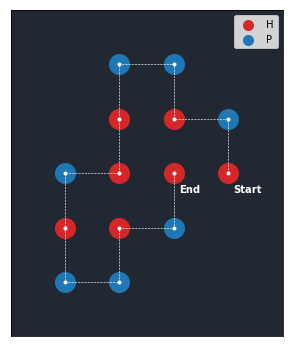


                                   ENVIRONMENT SUMMARY                                    
 Sequence   : H P H P P H H P H P P H P H
 Length     : 14
 Collision  : False
 Energy     : -6
 Reward     : 7.2
 Iteration  : 12
 Actions    : Left > Right > Left > Left > Forward > Right > Left > Forward > Left >
              Left > Right > Left
                                                                                          


In [7]:
# ==================================================================================================== #
#                                     Q-LEARNING : TESTING AGENT                                       #
# ==================================================================================================== #

# CREATE ENVIRONMENT
# ------------------
env = ProteinFoldingEnv(SEQUENCE_Q, valid_state_reward = 0.1, collision_reward = 0)

# TEST Q-LEARNING AGENT
# ---------------------
state = env.reset()
done = False
while not done:
    # Pick Next Action (via greedy policy)
    action = q_agent.act(state, policy='greedy')
    # Advance to next step
    state, reward, done, info = env.step(action)
env.render()
print(env.summary())

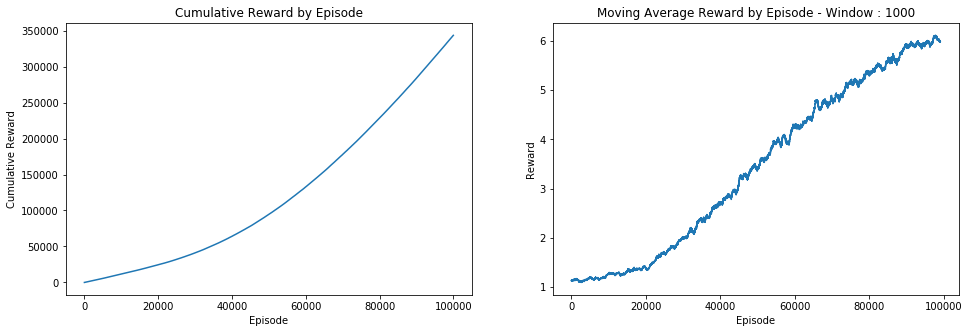

In [8]:
# ==================================================================================================== #
#                            Q-LEARNING : EVALUATE LEARNING PERFORMANCE                                #
# ==================================================================================================== #

# CREATE FIGURE
# -------------
plt.figure(figsize=(16,5))

# Cumulative Reward
plt.subplot(1,2,1)
q_rewards_cumul = np.cumsum(q_rewards)
plt.plot(q_rewards_cumul)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode')

# Moving Average Reward
plt.subplot(1,2,2)
step = int(EPISODES_Q/100)
q_rewards_ma = moving_average(q_rewards, step)
plt.plot(q_rewards_ma)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Moving Average Reward by Episode - Window : {}'.format(step));

### &nbsp; &nbsp; &nbsp; &nbsp; 2. Deep Q-Network (DQN)

In [0]:
# ==================================================================================================== #
#                                   CLASS DEFINITION : DEEP Q-NETWORK                                  #
# ==================================================================================================== #

# CLASS DEFINITION : MEMORY
# -------------------------
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class Memory:
    def __init__(self, capacity=10000):
        """Initializes a Memory Buffer."""
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def __len__(self):
        """Returns number of elements in the buffer."""
        return len(self.buffer)
    
    def push(self, *args):
        """Adds a new transition to the buffer."""
        self.buffer.append(Transition(*args))
        
    def sample(self, batch_size):
        """Sample a batch from the buffer."""
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))        
        return batch
        

# CLASS DEFINITION : DEEP Q-NETWORK AGENT
# ---------------------------------------
class DQNAgent:
    def __init__(self, input_dim, nb_actions, learning_rate = 0.001, batch_size = 32, memory_capacity=10000, gamma = 0.95, epsilon = 1.0, epsilon_min = 0.05, epsilon_decay = 0.99997):
        """Initializes a Deep Q-Network (DQN) Agent."""
        # Parameters
        self.input_dim = input_dim
        self.nb_actions = nb_actions
        self.memory = Memory(capacity=memory_capacity)
        self.gamma = gamma   # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay  # Decay
        self.learning_rate = learning_rate 
        self.batch_size = batch_size
        # Models
        self.policy_network = self._build_model()

        
    def _build_model(self):
        """Builds architecture of neural network."""
        model = Sequential()
        model.add(Dense(16, input_dim=self.input_dim, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.nb_actions, activation='linear'))
        model.compile(loss=Huber(), optimizer=Adam(lr=self.learning_rate))
        return model

        
    def remember(self, state, action, next_state, reward, done):
        """Stores memory of experienced events."""
        self.memory.push(state, action, next_state, reward, done)

        
    def act(self, state, policy='egreedy'):
        """Method to select an action according to a policy."""
        if policy == 'egreedy' : # e-greedy policy    
            if np.random.uniform(0, 1) > self.epsilon : # With probability (1-epsilon), take the best action (exploit, Greedy Policy)
                action = np.argmax(self.policy_network.predict(state.reshape(1,-1)).squeeze(0))         
            else : # With probability epsilon, take random action (explore)
                action = np.random.choice(self.nb_actions)
        else : # greedy policy
            action = np.argmax(self.policy_network.predict(state.reshape(1,-1)).squeeze(0))
        return action

    
    def train(self):
        """Trains the policy neural network using transitions randomly sampled from memory."""
        if len(self.memory) < self.batch_size:
            return {'loss':[np.nan]}
        
        batch = self.memory.sample(self.batch_size)
        input_batch = np.vstack(batch.state)
        target_batch = self.policy_network.predict(input_batch)
        next_Q = self.policy_network.predict(np.vstack(batch.next_state))
        ix = np.arange(self.batch_size)
        target_batch[ix, batch.action] = np.array(batch.reward) + (1 - np.array(batch.done)) * self.gamma * np.max(next_Q, axis=1)       
        history = self.policy_network.fit(input_batch, target_batch, batch_size=self.batch_size, epochs=1, verbose=0)
        return history.history

    
    def save(self, fname='../models/model.h5'):
        """Method to save the Policy Network of a DQN agent."""
        self.policy_network.save(fname)
        return None

    
    @staticmethod
    def load(fname):
        """Method to load a Policy Network in a new DQN agent."""
        agent = DQNAgent(14, 3)
        agent.policy_network = load_model(fname)
        return agent
        

In [28]:
# ==================================================================================================== #
#                                DEEP Q-NETWORK : TRAINING EXPERIMENT                                  #
# ==================================================================================================== #

# CREATE ENVIRONMENT
# ------------------
SEQUENCE_DQN = seq4
env = ProteinFoldingEnv(SEQUENCE_DQN, valid_state_reward = 0.1, collision_reward = 0) 

# CREATE DEEP Q-NETWORK AGENT
# ---------------------------
input_dim = env.size - 2
nb_actions = env.action_space.n
EPISODES_DQN = 200000
dqn_agent = DQNAgent(input_dim, nb_actions, learning_rate=0.001, epsilon_decay=np.exp(np.log(0.05)/EPISODES_DQN))

# TRAIN AGENT
# -----------
dqn_rewards = []
dqn_losses = []
print('TRAINING STARTED ...')
for episode in range(1, EPISODES_DQN+1):
    # Reset Environment
    state = env.reset(state_nn=True)
    done = False
    while not done:
        # Pick Next Action (via e-greedy policy)
        action = dqn_agent.act(state, policy='egreedy') 
        # Advance to next state
        next_state, reward, done, info = env.step(action, state_nn=True) 
        # Remember Experience
        dqn_agent.remember(state, action, next_state, reward, done)
        state = next_state
    # Train agent
    history = dqn_agent.train()
    if episode % 500 == 0:
        print('   Episode: {}/{} - Loss: {:.3f} - Reward: {:.2f} - Epsilon: {:.2f}.'.format(episode, EPISODES_DQN, history['loss'][0], env.reward, dqn_agent.epsilon))    
        K.clear_session()
    if dqn_agent.epsilon >= dqn_agent.epsilon_min : dqn_agent.epsilon *= dqn_agent.epsilon_decay
    dqn_rewards.append(env.reward)  
    dqn_losses.append(history['loss'][0])
print('TRAINING FINISHED !')


TRAINING STARTED ...
   Episode: 500/200000 - Loss: 0.011 - Reward: 1.20 - Epsilon: 0.99.
   Episode: 1000/200000 - Loss: 0.002 - Reward: 1.20 - Epsilon: 0.99.
   Episode: 1500/200000 - Loss: 0.007 - Reward: 2.20 - Epsilon: 0.98.
   Episode: 2000/200000 - Loss: 0.014 - Reward: 0.40 - Epsilon: 0.97.
   Episode: 2500/200000 - Loss: 0.006 - Reward: 2.20 - Epsilon: 0.96.
   Episode: 3000/200000 - Loss: 0.007 - Reward: 1.20 - Epsilon: 0.96.
   Episode: 3500/200000 - Loss: 0.006 - Reward: 0.80 - Epsilon: 0.95.
   Episode: 4000/200000 - Loss: 0.010 - Reward: 0.20 - Epsilon: 0.94.
   Episode: 4500/200000 - Loss: 0.012 - Reward: 2.20 - Epsilon: 0.93.
   Episode: 5000/200000 - Loss: 0.006 - Reward: 0.50 - Epsilon: 0.93.
   Episode: 5500/200000 - Loss: 0.003 - Reward: 2.20 - Epsilon: 0.92.
   Episode: 6000/200000 - Loss: 0.003 - Reward: 1.20 - Epsilon: 0.91.
   Episode: 6500/200000 - Loss: 0.018 - Reward: 0.40 - Epsilon: 0.91.
   Episode: 7000/200000 - Loss: 0.004 - Reward: 3.20 - Epsilon: 0.90.


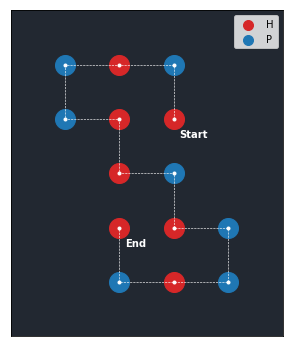


                                   ENVIRONMENT SUMMARY                                    
 Sequence   : H P H P P H H P H P P H P H
 Length     : 14
 Collision  : False
 Energy     : -5
 Reward     : 6.2
 Iteration  : 12
 Actions    : Left > Forward > Left > Left > Right > Left > Right > Left > Right >
              Right > Forward > Right
                                                                                          


In [29]:
# ==================================================================================================== #
#                                    DEEP Q-NETWORK : TESTING AGENT                                    #
# ==================================================================================================== #

# CREATE ENVIRONMENT
# ------------------
env = ProteinFoldingEnv(SEQUENCE_DQN, valid_state_reward = 0.1, collision_reward = 0)

# TEST Q-LEARNING AGENT
# ---------------------
state = env.reset(state_nn=True)
done = False
while not done:
    # Pick Next Action (via greedy policy)
    action = dqn_agent.act(state, policy='greedy')
    # Advance To Next State
    state, reward, done, info = env.step(action, state_nn=True)
env.render()
print(env.summary())

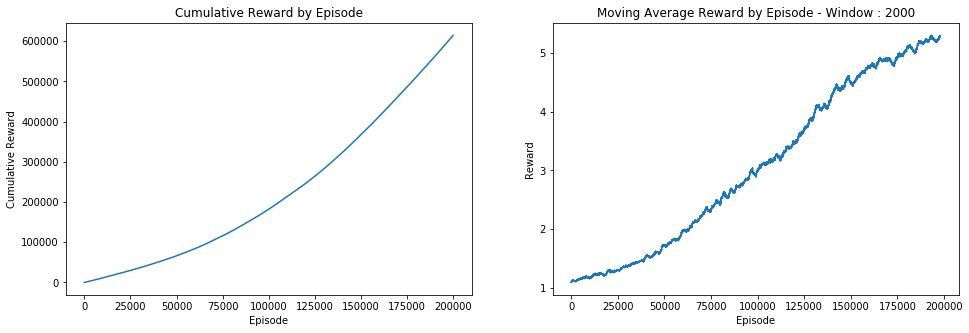

In [37]:
# ==================================================================================================== #
#                           DEEP Q-NETWORK : EVALUATE LEARNING PERFORMANCE                             #
# ==================================================================================================== #

# CREATE FIGURE
# -------------
plt.figure(figsize=(16,5))

# Cumulative Reward
plt.subplot(1,2,1)
dqn_rewards_cumul = np.cumsum(dqn_rewards)
plt.plot(dqn_rewards_cumul)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode')

# Moving Average Reward
plt.subplot(1,2,2)
step = int(EPISODES_DQN/100)
dqn_rewards_ma = moving_average(dqn_rewards, step)
plt.plot(dqn_rewards_ma)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Moving Average Reward by Episode - Window : {}'.format(step));

### &nbsp; &nbsp; &nbsp; &nbsp; 3. Double Deep Q-Network (Double DQN)

In [0]:
# ==================================================================================================== #
#                              CLASS DEFINITION : DOUBLE DEEP Q-NETWORK                                #
# ==================================================================================================== #

# CLASS DEFINITION : MEMORY
# -------------------------
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class Memory:
    def __init__(self, capacity=10000):
        """Initializes a Memory Buffer."""
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        
    def __len__(self):
        """Returns number of elements in the buffer."""
        return len(self.buffer)
    
    def push(self, *args):
        """Adds a new transition to the buffer."""
        self.buffer.append(Transition(*args))
        
    def sample(self, batch_size):
        """Sample a batch from the buffer."""
        transitions = random.sample(self.buffer, batch_size)
        batch = Transition(*zip(*transitions))        
        return batch
        

# CLASS DEFINITION : DOUBLE DEEP Q-NETWORK AGENT
# ----------------------------------------------
class DDQNAgent:
    def __init__(self, input_dim, nb_actions, learning_rate = 0.001, batch_size = 64, target_update = 100, memory_capacity=10000, gamma = 0.95, epsilon = 1.0, epsilon_min = 0.05, epsilon_decay = 0.99997):
        """Initializes a Double Deep Q-Network (DDQN) Agent."""
        # Parameters
        self.input_dim = input_dim
        self.nb_actions = nb_actions
        self.memory = Memory(capacity=memory_capacity)
        self.gamma = gamma   # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay  # Decay
        self.learning_rate = learning_rate 
        self.batch_size = batch_size
        self.target_update = target_update
        # Models
        self.policy_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_network()

        
    def _build_model(self):
        """Builds architecture of neural network."""
        model = Sequential()
        model.add(Dense(16, input_dim=self.input_dim, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.nb_actions, activation='linear'))
        model.compile(loss=Huber(), optimizer=Adam(lr=self.learning_rate))
        return model
    
    
    def update_target_network(self):
        """Copy the weights from Model into Target_Model"""
        self.target_network.set_weights(self.policy_network.get_weights())

        
    def remember(self, state, action, next_state, reward, done):
        """Stores memory of experienced events."""
        self.memory.push(state, action, next_state, reward, done)

        
    def act(self, state, policy='egreedy'):
        """Method to select an action according to a policy."""
        if policy == 'egreedy' : # e-greedy policy    
            if np.random.uniform(0, 1) > self.epsilon : # With probability (1-epsilon), take the best action (exploit, Greedy Policy)
                action = np.argmax(self.policy_network.predict(state.reshape(1,-1)).squeeze(0))         
            else : # With probability epsilon, take random action (explore)
                action = np.random.choice(self.nb_actions)
        else : # greedy policy
            action = np.argmax(self.policy_network.predict(state.reshape(1,-1)).squeeze(0))
        return action

    
    def train(self):
        """Trains the neural network using experiences randomly sampled from memory."""
        if len(self.memory) < self.batch_size:
            return {'loss':[np.nan]}
        
        batch = self.memory.sample(self.batch_size)
        input_batch = np.vstack(batch.state)
        target_batch = self.policy_network.predict(input_batch)
        next_Q = self.target_network.predict(np.vstack(batch.next_state))
        ix = np.arange(self.batch_size)
        target_batch[ix, batch.action] = np.array(batch.reward) + (1 - np.array(batch.done)) * self.gamma * np.max(next_Q, axis=1)       
        history = self.policy_network.fit(input_batch, target_batch, batch_size=self.batch_size, epochs=1, verbose=0)
        return history.history

    
    def save(self, fname='../models/model.h5'):
        """Method to save the Policy Network of a DDQN agent."""
        self.policy_network.save(fname)
        return None

    
    @staticmethod
    def load(fname):
        """Method to load a Policy Network in a new DDQN agent."""
        agent = DDQNAgent(14, 3)
        agent.policy_network = load_model(fname)
        return agent
        

In [20]:
# ==================================================================================================== #
#                            DOUBLE DEEP Q-NETWORK : TRAINING EXPERIMENT                               #
# ==================================================================================================== #

# CREATE ENVIRONMENT
# ------------------
SEQUENCE_DDQN = seq4
env = ProteinFoldingEnv(SEQUENCE_DDQN, valid_state_reward = 0.1, collision_reward = 0) 

# CREATE DOUBLE DEEP Q-NETWORK AGENT
# ----------------------------------
state_size = env.size - 2
nb_actions = env.action_space.n
EPISODES_DDQN = 100000
ddqn_agent = DDQNAgent(state_size, nb_actions, learning_rate=0.001, epsilon_decay=np.exp(np.log(0.05)/EPISODES_DDQN))

# TRAIN AGENT
# -----------
ddqn_rewards = []
ddqn_losses = []
print('TRAINING STARTED ...')
for episode in range(1, EPISODES_DDQN+1):
    # Reset Environment
    state = env.reset(state_nn=True)
    done = False
    while not done:
        # Pick Next Action (via e-greedy policy)
        action = ddqn_agent.act(state, policy='egreedy') 
        # Advance to next state
        next_state, reward, done, info = env.step(action, state_nn=True) 
        # Remember Experience
        ddqn_agent.remember(state, action, next_state, reward, done)
        state = next_state         
    # Train agent
    history = ddqn_agent.train()
    if episode % 500 == 0:
        print('   Episode: {}/{} - Loss: {:.3f} - Reward: {:.2f} - Epsilon: {:.2f}.'.format(episode, EPISODES_DDQN, history['loss'][0], env.reward, ddqn_agent.epsilon))
        K.clear_session()
    if ddqn_agent.epsilon >= ddqn_agent.epsilon_min: ddqn_agent.epsilon *= ddqn_agent.epsilon_decay
    if episode % ddqn_agent.target_update == 0: ddqn_agent.update_target_network()
    ddqn_rewards.append(env.reward) 
    ddqn_losses.append(history['loss'][0])
print('TRAINING FINISHED !')

TRAINING STARTED ...
   Episode: 500/100000 - Loss: 0.027 - Reward: 0.40 - Epsilon: 0.99.
   Episode: 1000/100000 - Loss: 0.018 - Reward: 0.20 - Epsilon: 0.97.
   Episode: 1500/100000 - Loss: 0.013 - Reward: 0.40 - Epsilon: 0.96.
   Episode: 2000/100000 - Loss: 0.013 - Reward: 2.20 - Epsilon: 0.94.
   Episode: 2500/100000 - Loss: 0.004 - Reward: 3.20 - Epsilon: 0.93.
   Episode: 3000/100000 - Loss: 0.007 - Reward: 0.60 - Epsilon: 0.91.
   Episode: 3500/100000 - Loss: 0.011 - Reward: 0.20 - Epsilon: 0.90.
   Episode: 4000/100000 - Loss: 0.008 - Reward: 0.20 - Epsilon: 0.89.
   Episode: 4500/100000 - Loss: 0.011 - Reward: 1.10 - Epsilon: 0.87.
   Episode: 5000/100000 - Loss: 0.012 - Reward: 1.10 - Epsilon: 0.86.
   Episode: 5500/100000 - Loss: 0.006 - Reward: 2.20 - Epsilon: 0.85.
   Episode: 6000/100000 - Loss: 0.012 - Reward: 0.70 - Epsilon: 0.84.
   Episode: 6500/100000 - Loss: 0.008 - Reward: 0.20 - Epsilon: 0.82.
   Episode: 7000/100000 - Loss: 0.016 - Reward: 2.20 - Epsilon: 0.81.


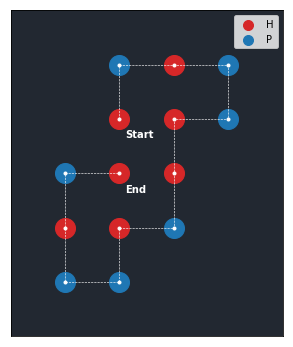


                                   ENVIRONMENT SUMMARY                                    
 Sequence   : H P H P P H H P H P P H P H
 Length     : 14
 Collision  : False
 Energy     : -6
 Reward     : 7.2
 Iteration  : 12
 Actions    : Right > Forward > Right > Right > Left > Forward > Right > Left > Right >
              Right > Forward > Right
                                                                                          


In [21]:
# ==================================================================================================== #
#                                DOUBLE DEEP Q-NETWORK : TESTING AGENT                                 #
# ==================================================================================================== #

# CREATE ENVIRONMENT
# ------------------
env = ProteinFoldingEnv(SEQUENCE_DDQN, valid_state_reward = 0.1, collision_reward = 0)

# TEST Q-LEARNING AGENT
# ---------------------
state = env.reset(state_nn=True)
done = False
while not done:
    # Pick Next Action (via greedy policy)
    action = ddqn_agent.act(state, policy='greedy')
    # Advance To Next State
    state, reward, done, info = env.step(action, state_nn=True)
env.render()
print(env.summary())

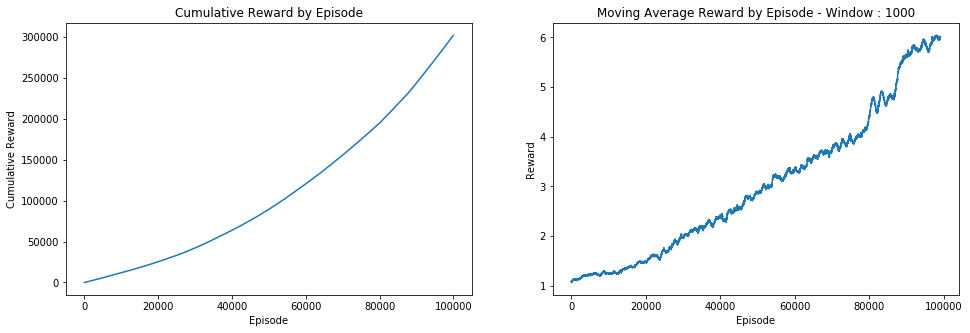

In [36]:
# ==================================================================================================== #
#                        DOUBLE DEEP Q-NETWORK : EVALUATE LEARNING PERFORMANCE                         #
# ==================================================================================================== #

# CREATE FIGURE
# -------------
plt.figure(figsize=(16,5))

# Cumulative Reward
plt.subplot(1,2,1)
ddqn_rewards_cumul = np.cumsum(ddqn_rewards)
plt.plot(ddqn_rewards_cumul)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward by Episode')

# Moving Average Reward
plt.subplot(1,2,2)
step = int(EPISODES_DDQN/100)
ddqn_rewards_ma = moving_average(ddqn_rewards, step)
plt.plot(ddqn_rewards_ma)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Moving Average Reward by Episode - Window : {}'.format(step));